In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("datasets/hotel_bookings.csv")

In [3]:
city = data[data.hotel == "City Hotel"]
num_of_rows = len(city.index)

In [4]:
# Customer/Market Segmentation

In [5]:
#Identifying the number of each occuring Customer type
adults = city["adults"].sum()
children = city["children"].sum()
babies = city["babies"].sum()

#Average customer constellation per Booking
avg_cust = (adults/num_of_rows, children/num_of_rows, babies/num_of_rows)

#Percentage of Group Bookings
per_of_groups = len(city[city["customer_type"] == "Group"].index)/num_of_rows
#Percentage of Transient Bookings
per_of_transients = len(city[city["customer_type"] == "Transient"].index)/num_of_rows
#Percentage of Contract Bookings
per_of_contracts = len(city[city["customer_type"] == "Contract"].index)/num_of_rows


#Group By Country
#First goup the rows in the country column by group and assign them to a variable
#Then zip the unique values and the corresponding size of each group into a tuple list, which will be sorted afterwards by compering on the
#snd tuple element => size. To plot the bar chart, the list must be unzipped again to be given as parameters for the plt function.
countries = city.groupby("country")
countries_unique = countries.country.unique()
countries_size = countries.size()
country_list = list(zip(countries_unique, countries_size))
rev_countries = sorted(country_list, key = lambda x: x[1])[::-1] #sorts from min to max, hence a reverse
topten_countries_list = rev_countries[0:10]
unzipped_countries_list = [[ i for i, j in topten_countries_list ], 
       [ j for i, j in topten_countries_list ]]
(topten_countries_names, topten_countries_sizes) = (unzipped_countries_list[0], unzipped_countries_list[1])

#Extracting the names from the array objects
def extract_names(names):
    res = []
    for e in names:
        res = res + e.tolist()
    return res

topten_countries_names = extract_names(topten_countries_names)


#Market Segment and Distribution Channels
market_segmentation = city["market_segment"].describe()
top_market = market_segmentation[2]
top_market_share = market_segmentation[3]/market_segmentation[0]

distribution_channels = city["distribution_channel"].describe()
top_distribution = distribution_channels[2]
top_distribution_share = distribution_channels[3]/distribution_channels[0]

#Identifying the most frequent occuring Travel Agency
top_three_agents = city["agent"].value_counts(normalize = True).head(3).to_dict() #Into a dict to plot in bar chart

[Text(0, 0.5, 'Share of total Distribution(%)'),
 Text(0.5, 0, 'Travel Agencies (No names available thus ids)')]

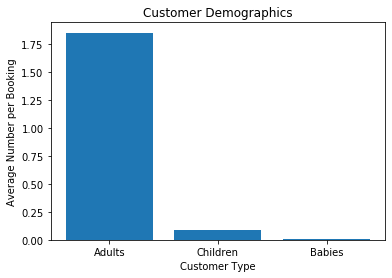

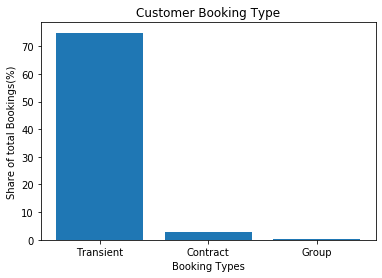

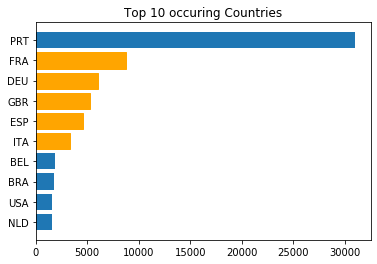

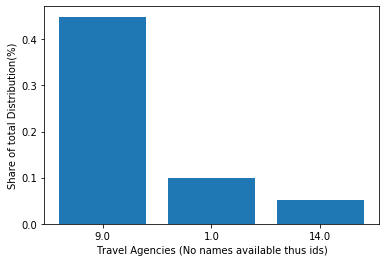

In [6]:
# Plotting Segmentations

#Customer Demographics Bar Chart
fig, ax = plt.subplots()
ax.bar(["Adults", "Children", "Babies"],avg_cust)
ax.set(ylabel = "Average Number per Booking", xlabel = "Customer Type", title = "Customer Demographics")

#Booking type Bar Chart
fig2, ax2 = plt.subplots()
ax2.bar(["Transient", "Contract", "Group"],[per_of_transients*100, per_of_contracts*100, per_of_groups*100])
ax2.set(ylabel = "Share of total Bookings(%)", xlabel = "Booking Types", title = "Customer Booking Type")

#Country Bar Chart
fig3, ax3 = plt.subplots()
ax3.barh(topten_countries_names[::-1], topten_countries_sizes[::-1])

for i in range(8,3,-1):
    ax3.get_children()[i].set_color('orange')
    
ax3.set(title = "Top 10 occuring Countries")

#Distribution Channel Bar Chart
fig4, ax4 = plt.subplots()
ids = list(top_three_agents.keys())
ax4.bar(range(len(top_three_agents)), top_three_agents.values(), tick_label = ids, align = "center")
ax4.set(ylabel = "Share of total Distribution(%)", xlabel = "Travel Agencies (No names available thus ids)")

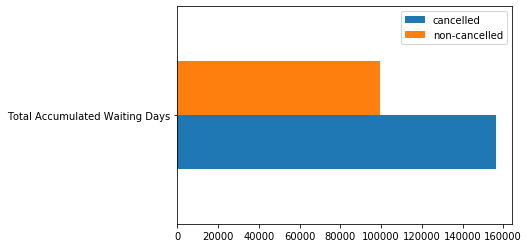

In [7]:
#Identify Cancellation Rate and analyzing potential Reasons
cancelations = city[city["is_canceled"] == 1]
non_cancels = city[city["is_canceled"] == 0]
cancel_rate = len(cancelations.index)/num_of_rows

#Potential Reason1: Too much waiting time until confirmation
wait_cancel = cancelations["days_in_waiting_list"].sum()
wait_non_cancel = non_cancels["days_in_waiting_list"].sum()

waiting_days_df = pd.DataFrame({
    "cancelled": wait_cancel,
    "non-cancelled": wait_non_cancel
}, index = ["Total Accumulated Waiting Days"])

ax5 = waiting_days_df.plot.barh()

#Potential Reason2: Different Room assignment than the one reserved
correct_room_assignment = city.loc[city["assigned_room_type"] == city["reserved_room_type"]]
assignment_rate = len(correct_room_assignment.index)/num_of_rows

#Potential Reason3: There are marginal repeated Guests --> no recommendations or returns
repeated_guests_rate = len(city[city["is_repeated_guest"] == 1])/num_of_rows

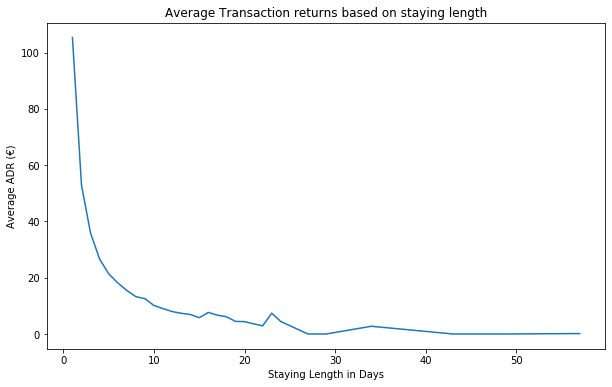

In [15]:
#Optimizing Daily Rates

sum_stays = non_cancels["stays_in_week_nights"] + non_cancels["stays_in_weekend_nights"]
totalstays_and_adr = non_cancels[["stays_in_week_nights", "stays_in_weekend_nights","adr"]].copy()
totalstays_and_adr["total_stays"] = sum_stays
totalstays_and_adr["weekend_ratio"] = totalstays_and_adr["stays_in_weekend_nights"]/totalstays_and_adr["stays_in_week_nights"]

#Optimal Staying Length = maximum Average Daily Rate (sum of all lodging transaction / number of staying days)
adr_per_numberofdays = totalstays_and_adr.groupby("total_stays").sum()
adr_per_numberofdays["avg_adr"] = adr_per_numberofdays["adr"]/(adr_per_numberofdays["stays_in_week_nights"] + adr_per_numberofdays["stays_in_weekend_nights"])
average_rates = adr_per_numberofdays["avg_adr"].tolist()
total_stays = adr_per_numberofdays.index.tolist()

#Plot the adr curve to see correltation between staying days and average daily rates
fig6, ax6 = plt.subplots(figsize = (10,6))
ax6.set(xlabel = "Staying Length in Days", ylabel = "Average ADR (€)", title = "Average Transaction returns based on staying length")
ax6.plot(total_stays, average_rates,)